In [269]:
import pandas as pd
import numpy as np
import json
from os.path import exists, join
from matplotlib import pyplot as plt
from scipy.stats.mstats import ttest_ind
from scipy.stats import fisher_exact
from scipy.stats import mannwhitneyu
from scipy.stats import levene
from unicodedata import normalize
import statsmodels.api as sm
import statsmodels as prp
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import os
import csv
import json
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from json.decoder import JSONDecodeError
from scipy.stats import ttest_ind

from unicodedata import normalize
import statsmodels.api as sm
import statsmodels as prp
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import math

In [270]:
def calculaTabela(agrupado, banco):  
    desfecho = 'gender'
    prop_genero = calculaProporcaoQualitativo(agrupado, desfecho)
    colunas = ["M - Média (desvio padrão)", "M - Min - Máx", "F - Média (desvio padrão)", "F - Min - Máx"]
    prop_genero.columns = colunas
    ##'wos_publications','citations','citations_per_item','citations_per_year','h_index'

    #var = "hIndex"
    var = "h_index"
    tabela_hindex = calculaProporcao(agrupado, var)
    t_hindex_mann = round(calcTesteHipoteseMannWhitney(banco, desfecho, "M", "F", var).pvalue, ndigits=4)

    #var = "numPublicationsInWos"
    var = "wos_publications"
    tabela_numpublicacoes = calculaProporcao(agrupado, var)
    t_numpublicacoes_mann = round(calcTesteHipoteseMannWhitney(banco, desfecho, "M", "F", var).pvalue, ndigits=4)

    #var = "timesCited"
    var = "citations"
    tabela_timescited = calculaProporcao(agrupado, var)
    t_timescited_mann = round(calcTesteHipoteseMannWhitney(banco, desfecho, "M", "F", var).pvalue, ndigits=4)

    #var = "averagePerItem"
    var = "citations_per_item"
    tabela_averageperitem = calculaProporcao(agrupado, var)
    t_averageperitem_mann = round(calcTesteHipoteseMannWhitney(banco, desfecho, "M", "F", var).pvalue, ndigits=4)

    #var = "averagePerYear"
    var = "citations_per_year"
    tabela_averageperyear = calculaProporcao(agrupado, var)
    t_averageperyear_mann = round(calcTesteHipoteseMannWhitney(banco, desfecho, "M", "F", var).pvalue, ndigits=4)

    #var = "timesCited"
    var_original = "citations"
    var = "citations_log"
    banco[var] = [math.log(x+1) for x in banco[var_original]]
    tabela_timescited_log = calculaProporcao(agrupado, var)
    t_timescited_mann_log = round(calcTesteHipoteseMannWhitney(banco, desfecho, "M", "F", var).pvalue, ndigits=4)

    #var = "averagePerItem"
    var_original = "citations_per_item"
    var = "citations_per_item_log"
    banco[var] = [math.log(x+1) for x in banco[var_original]]
    tabela_averageperitem_log = calculaProporcao(agrupado, var)
    t_averageperitem_mann_log = round(calcTesteHipoteseMannWhitney(banco, desfecho, "M", "F", var).pvalue, ndigits=4)

    #var = "averagePerYear"
    var_original = "citations_per_year"
    var = "citations_per_year_log"
    banco[var] = [math.log(x+1) for x in banco[var_original]]
    tabela_averageperyear_log = calculaProporcao(agrupado, var)
    t_averageperyear_mann_log = round(calcTesteHipoteseMannWhitney(banco, desfecho, "M", "F", var).pvalue, ndigits=4)

    cabecalho = pd.Series(["Frequencia",
                 "Índice H", 
                 "Número de publicações no Web of science", 
                 "Total de citações", 
                 "Média de citações por item",
                 "Média de citações por ano",
                 "Total de citações (escala log)",
                 "Média de citações por item (escala log)",
                 "Média de citações por ano (escala log)"
                 ])

    compilado = pd.concat([
         prop_genero,
         tabela_hindex,
         tabela_numpublicacoes,
         tabela_timescited,
         tabela_averageperitem,
         tabela_averageperyear,
         tabela_timescited_log,
         tabela_averageperitem_log,
         tabela_averageperyear_log
               ], axis=0)

    testes_mann = ["", 
                   t_hindex_mann, 
                   t_numpublicacoes_mann, 
                   t_timescited_mann, 
                   t_averageperitem_mann, 
                   t_averageperyear_mann, 
                   t_timescited_mann_log, 
                   t_averageperitem_mann_log, 
                   t_averageperyear_mann_log]

    compilado = pd.concat([compilado.reset_index(drop=True), 
                           pd.Series(testes_mann).reset_index(drop=True)], axis=1)

    compilado.index = cabecalho
    compilado.columns = ["M - Média (desvio padrão)", "M - Min - Máx", "F - Média (desvio padrão)", "F - Min - Máx", "p-value (mann)"]
    #print(compilado) 
    return compilado



def calculaProporcao(agrupado, var): 
    calc_media = round(agrupado[var].mean(), ndigits=2).map(str) + " (±" + round(agrupado[var].std(), ndigits=2).map(str) + ")" 
    calc_range = round(agrupado[var].min(), ndigits=2).map(str) + " - " + round(agrupado[var].max(), ndigits=2).map(str)
    calc_proporcao = round(agrupado[var].sum(), ndigits=2).map(str) + \
                           " (" + round(agrupado[var].sum()/sum(agrupado[var].sum()) * 100, ndigits=2).map(str) + " %)"  
    #tabela = pd.concat([calc_media, calc_range, calc_proporcao], axis=1)
    colunas = ["M - Média (desvio padrão)", "M - Min - Máx", "F - Média (desvio padrão)", "F - Min - Máx"]  
    tabela = pd.DataFrame(data=[[calc_media['M'], calc_range['M'], calc_media['F'], calc_range['F']]], 
                         columns=colunas)     

    return tabela 


def calcTesteHipotese(banco, col_parametro, param_1, param_2, desfecho):
    banco_1 =  banco[banco[col_parametro] == param_1]  
    banco_2 =  banco[banco[col_parametro] == param_2]  
    calc_ttest = (ttest_ind(banco_1[~np.isnan(banco_1[desfecho])][desfecho], 
                            banco_2[~np.isnan(banco_2[desfecho])][desfecho]))
    return calc_ttest


def calcTesteHipoteseMannWhitney(banco, col_parametro, param_1, param_2, desfecho):
    banco_1 =  banco[banco[col_parametro] == param_1]  
    banco_2 =  banco[banco[col_parametro] == param_2]
    calc_ttest = (mannwhitneyu(banco_1[~np.isnan(banco_1[desfecho])][desfecho], 
                            banco_2[~np.isnan(banco_2[desfecho])][desfecho]))
    return calc_ttest

def calcTesteHipoteseLevene(banco, col_parametro, param_1, param_2, desfecho):
    banco_1 =  banco[banco[col_parametro] == param_1]  
    banco_2 =  banco[banco[col_parametro] == param_2]
    calc_ttest = (levene(banco_1[~np.isnan(banco_1[desfecho])][desfecho], 
                            banco_2[~np.isnan(banco_2[desfecho])][desfecho]))
    return calc_ttest



def calculaProporcaoQualitativo(agrupado, var): 
    calc_proporcao = "n = " + round(agrupado[var].value_counts(), ndigits=2).map(str) + \
                            " (" + round(agrupado[var].value_counts()/sum(agrupado[var].value_counts()) * 100, ndigits=2).map(str) + " %)"
    tabela = pd.DataFrame(data=pd.Series(list(calc_proporcao)))
    colunas = ["M", "", "F", ""]  
    tabela = pd.DataFrame(data=[[calc_proporcao[1], "", calc_proporcao[0], ""]], 
                         columns=colunas) 
    return tabela


In [271]:
#####Tabela de proporcao e piramide

def calculaProporcao_IC(agrupado, var):
    tabela = pd.DataFrame;
    nova_coluna = []
    for i in range(len(list(agrupado.groups))):    
        coluna = agrupado.get_group(list(agrupado.groups)[i])
        nova_coluna.append(list(agrupado.groups)[i])
        
        calc_proporcao = pd.concat([coluna[var].value_counts()], axis=1, sort=False)
        
        nome_linhas = list(calc_proporcao.index.categories)
        #nome_linhas.append("Total")
        
        #print(calc_proporcao)
        
        calc_proporcao =  pd.DataFrame(calc_proporcao, index=list(nome_linhas))
        if i > 0:
            tabela = pd.concat([tabela, calc_proporcao], axis=1, sort=False)
        else:
            tabela = calc_proporcao
        
        #print(tabela)
    
        tabela.index = nome_linhas
        
    tabela.columns = nova_coluna
    ic = []
    ic_95 = []
    ic_str = []
    for i in range(len(list(tabela.F))):
        if(list(tabela.F)[i] > 0):
            prop = round(list(tabela.M)[i]/list(tabela.F)[i], ndigits=2)
            ic_prop = re_round([x/(1-x) for x in list(
                prp.stats.proportion.proportion_confint(
                    list(tabela.M)[i], list(tabela.M)[i]+list(tabela.F)[i], 
                    alpha=0.05, method='normal'))])
        else:
            prop = " - "
            ic_pro = ["", ""]
            
        ic.append(prop)
        ic_95.append(ic_prop)
        ic_str.append(str(prop).replace(".",",") + " " + 
                      str(ic_prop).replace("[","(").replace("]",")").replace(", ","-").replace(".",","))
        
    intervalos = pd.DataFrame(ic_str, columns =['IC (IC 95%)']) 
    
    intervalos.index = nome_linhas
        
    #print(intervalos)

    return intervalos

def re_round(li, _prec=2):
     try:
         return round(li, _prec)
     except TypeError:
         return type(li)(re_round(x, _prec) for x in li)
     

def myround(x, base=5):
    return base * round(x/base)

def criaPiramideDoIndiceH(prop_genero, xlabel="Número de docentes", titulo="Pirâmide do Índice H por Gênero", 
                          xlim = 500, path="D:\\Google Drive\\Aluna Livia Ciabati\\Pesquisa e gênero\\", 
                          pasta_img="piramide\\", nome_figura="populacao_geral.png"):    
    faixa = list(prop_genero.index.values[:-1])
    
    women_pop = list(prop_genero.F_Num)[:-1]
    men_pop   = list(prop_genero.M_Num)[:-1]
    men_pop = [element * -1 for element in men_pop]
    
    #genero, categoria, total_cat
    col_gen_m = ['M' for element in men_pop]
    col_gen_f = ['F' for element in men_pop]
    
    col_gen = col_gen_m + col_gen_f
    col_cat = faixa + faixa
    col_total_cat = men_pop + women_pop
    
    df = pd.DataFrame({'genero': col_gen, 
                    'categoria': col_cat, 
                    'total_cat': col_total_cat})    
    
    # Draw Plot
    plt.figure(figsize=(16,10), dpi= 200)
    
    group_col = 'genero'
    order_of_bars = df.categoria.unique()[::-1]
    colors = [plt.cm.Spectral(i/float(len(df[group_col].unique())-1)) for i in range(len(df[group_col].unique()))]
        
    for c, group in zip(colors, df[group_col].unique()):
        if(group == "M"):
            label = "Masculino"
        else:
            label = "Feminino"
        sns.barplot(x='total_cat', y='categoria', data=df.loc[df[group_col]==group, :], order=order_of_bars, color=c, label=label)
        
    # Decorations    
    plt.xlabel(xlabel, fontsize=18)
    
    plt.xlim(-xlim, xlim)
    plt.ylabel("Índice H", fontsize=18)
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)
    ##plt.title(titulo, fontsize=22)
    plt.legend()
        
    plt.savefig(path + pasta_img + nome_figura + '.svg', format='svg', dpi=1200)
    plt.savefig(path + pasta_img + nome_figura + '.png', format='png', dpi=1200)    
    plt.savefig(path + pasta_img + nome_figura + '_low.png', format='png', dpi=200)
        
        
    plt.show()

def calculaProporcaoQualitativoMultiCategoria(agrupado, var):     
    tabela = pd.DataFrame;
    nova_coluna = []
    for i in range(len(list(agrupado.groups))):    
        coluna = agrupado.get_group(list(agrupado.groups)[i])
        nova_coluna.append(list(agrupado.groups)[i])
        nova_coluna.append(list(agrupado.groups)[i] + "_Num")
        
        calc_proporcao = pd.concat([round(coluna[var].value_counts(), ndigits=2).map(str) + \
                            " (" + round(coluna[var].value_counts()/sum(coluna[var].value_counts()) * 100, ndigits=2).map(str) + " %)",
                            coluna[var].value_counts()], axis=1, sort=False)
        
        #print(calc_proporcao)
        nome_linhas = list(calc_proporcao.index.categories)
        
        
        calc_proporcao =  pd.DataFrame(calc_proporcao, index=list(nome_linhas))
        nome_linhas.append("Total")
        
        newDF = pd.DataFrame(["",coluna[var].count()]).T
        newDF.columns = [var, var]
        calc_proporcao_total = pd.concat([calc_proporcao, newDF], ignore_index=True)
        
        calc_proporcao_total.index = nome_linhas
        
        #print(calc_proporcao)
        
        if i > 0:
            tabela = pd.concat([tabela, calc_proporcao_total], axis=1, sort=False)
        else:
            tabela = calc_proporcao_total
        #print(tabela)
        tabela.index = nome_linhas
        
    tabela.columns = nova_coluna
    return tabela

In [272]:
#Caminho base
path = "D:\\Google Drive\\Aluna Livia Ciabati\\Pesquisa e gênero\\"

###Le o banco de análise anonimizado
banco_completo_com_depto = pd.read_csv(path + '2020-06-24_publicacao_e_genero\\results\\results_publons_gender_time_anonymized.csv', sep=",", header=0, engine='python', encoding="utf-8")
print(banco_completo_com_depto.shape)

# Verifica quantos pesquisadores não possuem citações
rows_to_drop = banco_completo_com_depto.loc[(banco_completo_com_depto.h_index.isna())].index
print('Pesquisadores sem citacões ou h_index: ', len(rows_to_drop))

banco_completo_com_depto = banco_completo_com_depto.drop(rows_to_drop, axis=0)
df_size = len(banco_completo_com_depto.index)
print('Banco final: ', df_size)

banco_completo_com_depto.head()


(3072, 9)
Pesquisadores sem citacões ou h_index:  5
Banco final:  3067


,wos_publications,citations,citations_per_item,citations_per_year,h_index,gender,time,usp_unit,usp_dept
0,245,4263,17.40,170.52,31.0,M,21,18,984
1,53,414,7.81,41.40,12.0,M,7,43,1564
2,77,620,8.05,31.00,15.0,M,15,17,2799
3,104,2528,24.31,63.20,26.0,F,44,17,2800
4,60,316,5.27,19.75,9.0,M,32,11,761


In [273]:
df = banco_completo_com_depto
all_people = df_size
df['gender'].value_counts()
men = df['gender'].value_counts()['M']
percentage_men = men/all_people*100

women = df['gender'].value_counts()['F']
percentage_women = women/all_people*100

print('Total de Docentes: ', all_people)
print('Homens: {} ({} % de {})'.format(men, round(percentage_men,2), all_people))
print('Mulheres: {} ({} % de {})'.format(women, round(percentage_women,2), all_people))

Total de Docentes:  3067
Homens: 1893 (61.72 % de 3067)
Mulheres: 1174 (38.28 % de 3067)


In [274]:
men_9 = len(df.loc[(df['time'] < 10) & (df['gender'] == 'M')].index)
men_10_19 = len(df.loc[(df['time'] < 20) & (df['time'] >= 10) & (df['gender'] == 'M')].index)
men_20 = len(df.loc[(df['time'] >= 20) & (df['gender'] == 'M')].index)


print('Total de Docentes: ', all_people)
print('Homens: {} ({} % de {})'.format(men, round(percentage_men,2), all_people))
print('Quantidade de homens com 9 ou menos anos de trabalho: {} ({} porcentagem de {})'
      .format(men_9, round(men_9/men*100,2), men))
print('Quantidade de homens com 10 a 19 anos de trabalho: {} ({} porcentagem de {})'
      .format(men_10_19, round(men_10_19/men*100,2), men))
print('Quantidade de homens com 20 ou mais anos de trabalho: {} ({} porcentagem de {})'
      .format(men_20, round(men_20/men*100,2), men))

Total de Docentes:  3067
Homens: 1893 (61.72 % de 3067)
Quantidade de homens com 9 ou menos anos de trabalho: 642 (33.91 porcentagem de 1893)
Quantidade de homens com 10 a 19 anos de trabalho: 605 (31.96 porcentagem de 1893)
Quantidade de homens com 20 ou mais anos de trabalho: 646 (34.13 porcentagem de 1893)


In [275]:
women_9 = len(df.loc[(df['time'] < 10) & (df['gender'] == 'F')].index)
women_10_19 = len(df.loc[(df['time'] < 20) & (df['time'] >= 10) & (df['gender'] == 'F')].index)
women_20 = len(df.loc[(df['time'] >= 20) & (df['gender'] == 'F')].index)

print('Total de Docentes: ', all_people)
print('Mulheres: {} ({} % de {})'.format(women, round(percentage_women,2), all_people))
print('Quantidade de mulheres com 9 ou menos anos de trabalho: {} ({} porcentagem de {})'
      .format(women_9, round(women_9/women*100,2), women))
print('Quantidade de mulheres com 10 a 19 anos de trabalho: {} ({} porcentagem de {})'
      .format(women_10_19, round(women_10_19/women*100,2), women))
print('Quantidade de mulheres com mais de 20 anos de trabalho: {} ({} porcentagem de {})'
      .format(women_20, round(women_20/women*100,2), women))

Total de Docentes:  3067
Mulheres: 1174 (38.28 % de 3067)
Quantidade de mulheres com 9 ou menos anos de trabalho: 379 (32.28 porcentagem de 1174)
Quantidade de mulheres com 10 a 19 anos de trabalho: 427 (36.37 porcentagem de 1174)
Quantidade de mulheres com mais de 20 anos de trabalho: 368 (31.35 porcentagem de 1174)


In [276]:
## analise da populacao geral
agrupado = banco_completo_com_depto.groupby("gender")
analise_pop_geral = calculaTabela(agrupado, banco_completo_com_depto)
analise_pop_geral

,M - Média (desvio padrão),M - Min - Máx,F - Média (desvio padrão),F - Min - Máx,p-value (mann)
Frequencia,n = 1893 (61.72 %),,n = 1174 (38.28 %),,
Índice H,14.5 (±11.43),0.0 - 100.0,12.38 (±9.16),0.0 - 54.0,0
Número de publicações no Web of science,67.05 (±78.9),1 - 694,49.67 (±53.37),1 - 550,0
Total de citações,1348.28 (±2656.42),0 - 36566,859.49 (±1301.2),0 - 13461,0
Média de citações por item,16.52 (±38.4),0.0 - 1536.0,14.23 (±14.06),0.0 - 240.3,0.0015
Média de citações por ano,53.97 (±109.53),0.0 - 2452.33,35.9 (±46.59),0.0 - 420.66,0
Total de citações (escala log),5.94 (±1.96),0.0 - 10.51,5.62 (±1.91),0.0 - 9.51,0
Média de citações por item (escala log),2.49 (±0.86),0.0 - 7.34,2.39 (±0.86),0.0 - 5.49,0.0015
Média de citações por ano (escala log),3.15 (±1.38),0.0 - 7.81,2.94 (±1.27),0.0 - 6.04,0


In [277]:
#analise com o ponto de corte do top 100
banco_ordenado = banco_completo_com_depto.sort_values(by="h_index", ascending=False).head(100)
banco_ordenado_ponto_corte = banco_completo_com_depto.sort_values(by="h_index", ascending=False)[banco_completo_com_depto.h_index >= banco_ordenado.h_index.min()]
agrupado_depto = banco_ordenado_ponto_corte.groupby('gender')
analise_100_ponto_corte = calculaTabela(agrupado_depto, banco_ordenado_ponto_corte)
analise_100_ponto_corte

C:\Users\Livia Ciabati\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,M - Média (desvio padrão),M - Min - Máx,F - Média (desvio padrão),F - Min - Máx,p-value (mann)
Frequencia,n = 93 (83.04 %),,n = 19 (16.96 %),,
Índice H,45.88 (±11.81),37.0 - 100.0,42.47 (±4.79),37.0 - 54.0,0.2891
Número de publicações no Web of science,265.34 (±138.43),80 - 694,228.47 (±122.8),88 - 550,0.1025
Total de citações,9552.09 (±6653.04),3966 - 36566,7129.21 (±2475.77),4501 - 13461,0.0938
Média de citações por item,39.79 (±26.87),10.82 - 216.38,35.19 (±13.33),20.09 - 71.35,0.4399
Média de citações por ano,335.17 (±331.83),67.08 - 2452.33,230.42 (±74.74),128.74 - 420.66,0.0874
Total de citações (escala log),9.01 (±0.52),8.29 - 10.51,8.82 (±0.31),8.41 - 9.51,0.0938
Média de citações por item (escala log),3.57 (±0.5),2.47 - 5.38,3.53 (±0.34),3.05 - 4.28,0.4399
Média de citações por ano (escala log),5.58 (±0.62),4.22 - 7.81,5.4 (±0.32),4.87 - 6.04,0.0874


In [278]:
### ponto de corte para tempo de servico   
num_anos=20
result_20_anos = banco_completo_com_depto[banco_completo_com_depto["time"] >= num_anos]
result_20_anos.shape
agrupado = result_20_anos.groupby("gender")
analise_pop_20 = calculaTabela(agrupado, result_20_anos)
analise_pop_20

C:\Users\Livia Ciabati\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Livia Ciabati\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Livia Ciabati\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

,M - Média (desvio padrão),M - Min - Máx,F - Média (desvio padrão),F - Min - Máx,p-value (mann)
Frequencia,n = 646 (63.71 %),,n = 368 (36.29 %),,
Índice H,16.89 (±11.84),0.0 - 74.0,15.46 (±10.36),0.0 - 54.0,0.0802
Número de publicações no Web of science,86.24 (±94.91),1 - 694,68.11 (±63.73),1 - 476,0.0298
Total de citações,1700.99 (±2735.52),0 - 36566,1247.33 (±1627.37),0 - 13461,0.0289
Média de citações por item,18.8 (±61.38),0.0 - 1536.0,15.14 (±13.19),0.0 - 146.25,0.0526
Média de citações por ano,58.01 (±90.0),0.0 - 1462.64,43.97 (±51.11),0.0 - 420.66,0.0593
Total de citações (escala log),6.36 (±1.83),0.0 - 10.51,6.16 (±1.79),0.0 - 9.51,0.0289
Média de citações por item (escala log),2.59 (±0.81),0.0 - 7.34,2.49 (±0.82),0.0 - 4.99,0.0526
Média de citações por ano (escala log),3.33 (±1.33),0.0 - 7.29,3.2 (±1.22),0.0 - 6.04,0.0593


In [279]:
banco_ordenado = result_20_anos.sort_values(by="h_index", ascending=False).head(100)
banco_ordenado_ponto_corte = result_20_anos.sort_values(by="h_index", ascending=False)[result_20_anos.h_index >= banco_ordenado.h_index.min()]
agrupado_depto = banco_ordenado_ponto_corte.groupby('gender')
analise_20_100_ponto_corte = calculaTabela(agrupado_depto, banco_ordenado_ponto_corte)
analise_20_100_ponto_corte

C:\Users\Livia Ciabati\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,M - Média (desvio padrão),M - Min - Máx,F - Média (desvio padrão),F - Min - Máx,p-value (mann)
Frequencia,n = 75 (70.75 %),,n = 31 (29.25 %),,
Índice H,39.99 (±8.1),32.0 - 74.0,36.77 (±5.18),32.0 - 54.0,0.0409
Número de publicações no Web of science,256.2 (±140.12),97 - 694,196.45 (±105.7),80 - 476,0.0055
Total de citações,6980.81 (±4876.05),2588 - 36566,5000.39 (±2483.52),2517 - 13461,0.0042
Média de citações por item,29.63 (±16.5),10.82 - 112.51,27.94 (±9.64),10.38 - 50.53,0.3258
Média de citações por ano,213.73 (±175.15),61.98 - 1462.64,154.1 (±77.78),66.24 - 420.66,0.0074
Total de citações (escala log),8.7 (±0.51),7.86 - 10.51,8.43 (±0.4),7.83 - 9.51,0.0042
Média de citações por item (escala log),3.32 (±0.44),2.47 - 4.73,3.31 (±0.35),2.43 - 3.94,0.3258
Média de citações por ano (escala log),5.21 (±0.52),4.14 - 7.29,4.94 (±0.45),4.21 - 6.04,0.0074


In [280]:
### ponto de corte para tempo de servico   
result_10_19_anos = banco_completo_com_depto[(banco_completo_com_depto["time"] >= 10) & (banco_completo_com_depto["time"] < 20)]
result_10_19_anos.shape
agrupado = result_10_19_anos.groupby("gender")
analise_pop_10_19 = calculaTabela(agrupado, result_10_19_anos)
analise_pop_10_19

C:\Users\Livia Ciabati\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Livia Ciabati\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Livia Ciabati\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

,M - Média (desvio padrão),M - Min - Máx,F - Média (desvio padrão),F - Min - Máx,p-value (mann)
Frequencia,n = 605 (58.62 %),,n = 427 (41.38 %),,
Índice H,13.29 (±10.74),0.0 - 100.0,11.23 (±8.57),0.0 - 53.0,0.0019
Número de publicações no Web of science,59.6 (±68.7),1 - 691,43.55 (±47.05),1 - 550,0.0002
Total de citações,1157.24 (±2738.76),0 - 34889,730.0 (±1206.23),0 - 11050,0.0003
Média de citações por item,14.81 (±16.01),0.0 - 216.38,13.87 (±16.55),0.0 - 240.3,0.032
Média de citações por ano,55.39 (±146.12),0.0 - 2452.33,34.93 (±48.33),0.0 - 333.33,0.0018
Total de citações (escala log),5.75 (±2.03),0.0 - 10.46,5.4 (±1.96),0.0 - 9.31,0.0003
Média de citações por item (escala log),2.41 (±0.89),0.0 - 5.38,2.33 (±0.9),0.0 - 5.49,0.032
Média de citações por ano (escala log),3.09 (±1.42),0.0 - 7.81,2.85 (±1.32),0.0 - 5.81,0.0018


In [281]:
banco_ordenado = result_10_19_anos.sort_values(by="h_index", ascending=False).head(100)
banco_ordenado_ponto_corte = result_10_19_anos.sort_values(by="h_index", ascending=False)[result_10_19_anos.h_index >= banco_ordenado.h_index.min()]
agrupado_depto = banco_ordenado_ponto_corte.groupby('gender')
analise_10_19_100_ponto_corte = calculaTabela(agrupado_depto, banco_ordenado_ponto_corte)
analise_10_19_100_ponto_corte

C:\Users\Livia Ciabati\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,M - Média (desvio padrão),M - Min - Máx,F - Média (desvio padrão),F - Min - Máx,p-value (mann)
Frequencia,n = 79 (71.82 %),,n = 31 (28.18 %),,
Índice H,32.85 (±12.16),25.0 - 100.0,31.74 (±7.42),25.0 - 53.0,0.358
Número de publicações no Web of science,171.01 (±107.16),33 - 691,137.81 (±90.09),52 - 550,0.0173
Total de citações,5003.52 (±6173.31),1703 - 34889,3693.52 (±2205.06),1514 - 11050,0.1293
Média de citações por item,30.56 (±29.18),8.38 - 216.38,29.13 (±13.72),13.69 - 71.35,0.2417
Média de citações por ano,232.3 (±350.62),55.49 - 2452.33,143.55 (±71.67),65.83 - 325.0,0.1083
Total de citações (escala log),8.23 (±0.63),7.44 - 10.46,8.08 (±0.51),7.32 - 9.31,0.1293
Média de citações por item (escala log),3.26 (±0.54),2.24 - 5.38,3.32 (±0.42),2.69 - 4.28,0.2417
Média de citações por ano (escala log),5.07 (±0.71),4.03 - 7.81,4.87 (±0.45),4.2 - 5.79,0.1083


In [282]:
### ponto de corte para tempo de servico   
num_anos = 10
result_10_anos = banco_completo_com_depto[(banco_completo_com_depto["time"] >= 0) & (banco_completo_com_depto["time"] < 10)]
result_10_anos.shape
agrupado = result_10_anos.groupby("gender")
analise_pop_10 = calculaTabela(agrupado, result_10_anos)
analise_pop_10

C:\Users\Livia Ciabati\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Livia Ciabati\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Livia Ciabati\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

,M - Média (desvio padrão),M - Min - Máx,F - Média (desvio padrão),F - Min - Máx,p-value (mann)
Frequencia,n = 642 (62.88 %),,n = 379 (37.12 %),,
Índice H,13.25 (±11.27),0.0 - 83.0,10.69 (±7.72),0.0 - 36.0,0.0031
Número de publicações no Web of science,54.78 (±65.52),1 - 461,38.66 (±43.66),1 - 314,0.0003
Total de citações,1173.4 (±2457.73),0 - 26011,628.81 (±907.9),0 - 6404,0.001
Média de citações por item,15.83 (±17.67),0.0 - 224.4,13.77 (±11.6),0.0 - 61.65,0.0869
Média de citações por ano,48.57 (±84.24),0.0 - 736.09,29.16 (±38.18),0.0 - 400.25,0.0029
Total de citações (escala log),5.71 (±1.96),0.0 - 10.17,5.34 (±1.86),0.0 - 8.76,0.001
Média de citações por item (escala log),2.46 (±0.88),0.0 - 5.42,2.38 (±0.86),0.0 - 4.14,0.0869
Média de citações por ano (escala log),3.03 (±1.37),0.0 - 6.6,2.77 (±1.23),0.0 - 5.99,0.0029


In [283]:
banco_ordenado_ponto_corte = result_10_anos.sort_values(by="h_index", ascending=False)[result_10_anos.h_index >= banco_ordenado.h_index.min()]
agrupado_depto = banco_ordenado_ponto_corte.groupby('gender')
analise_10_100_ponto_corte = calculaTabela(agrupado_depto, banco_ordenado_ponto_corte)
analise_10_100_ponto_corte

C:\Users\Livia Ciabati\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,M - Média (desvio padrão),M - Min - Máx,F - Média (desvio padrão),F - Min - Máx,p-value (mann)
Frequencia,n = 81 (77.14 %),,n = 24 (22.86 %),,
Índice H,36.23 (±11.35),25.0 - 83.0,29.29 (±3.87),25.0 - 36.0,0.0009
Número de publicações no Web of science,178.28 (±91.18),51 - 461,138.25 (±78.13),41 - 314,0.0218
Total de citações,5704.74 (±4635.64),1771 - 26011,3085.96 (±1269.24),1382 - 6404,0.0006
Média de citações por item,33.43 (±18.75),8.92 - 90.48,26.44 (±12.31),12.57 - 61.65,0.0533
Média de citações por ano,199.45 (±150.86),29.79 - 736.09,107.42 (±75.58),39.16 - 400.25,0.0004
Total de citações (escala log),8.43 (±0.62),7.48 - 10.17,7.96 (±0.4),7.23 - 8.76,0.0006
Média de citações por item (escala log),3.41 (±0.5),2.29 - 4.52,3.22 (±0.43),2.61 - 4.14,0.0533
Média de citações por ano (escala log),5.05 (±0.71),3.43 - 6.6,4.54 (±0.52),3.69 - 5.99,0.0004


In [284]:
writer = pd.ExcelWriter(path + "analise_professores_"+str(num_anos)+"_anos_mann_whitney.xlsx", engine = 'xlsxwriter')

analise_pop_geral.to_excel(writer, sheet_name = 'analise_pop_geral')
analise_100_ponto_corte.to_excel(writer, sheet_name = 'analise_100_ponto_corte')

analise_pop_20.to_excel(writer, sheet_name = 'analise_20')
analise_20_100_ponto_corte.to_excel(writer, sheet_name = 'analise_20_100_ponto_corte')

analise_pop_10_19.to_excel(writer, sheet_name = 'analise_10_19')
analise_10_19_100_ponto_corte.to_excel(writer, sheet_name = 'analise_10_19_100_ponto_corte')

analise_pop_10.to_excel(writer, sheet_name = 'analise_10')
analise_10_100_ponto_corte.to_excel(writer, sheet_name = 'analise_10_100_ponto_corte')

writer.save()
writer.close()


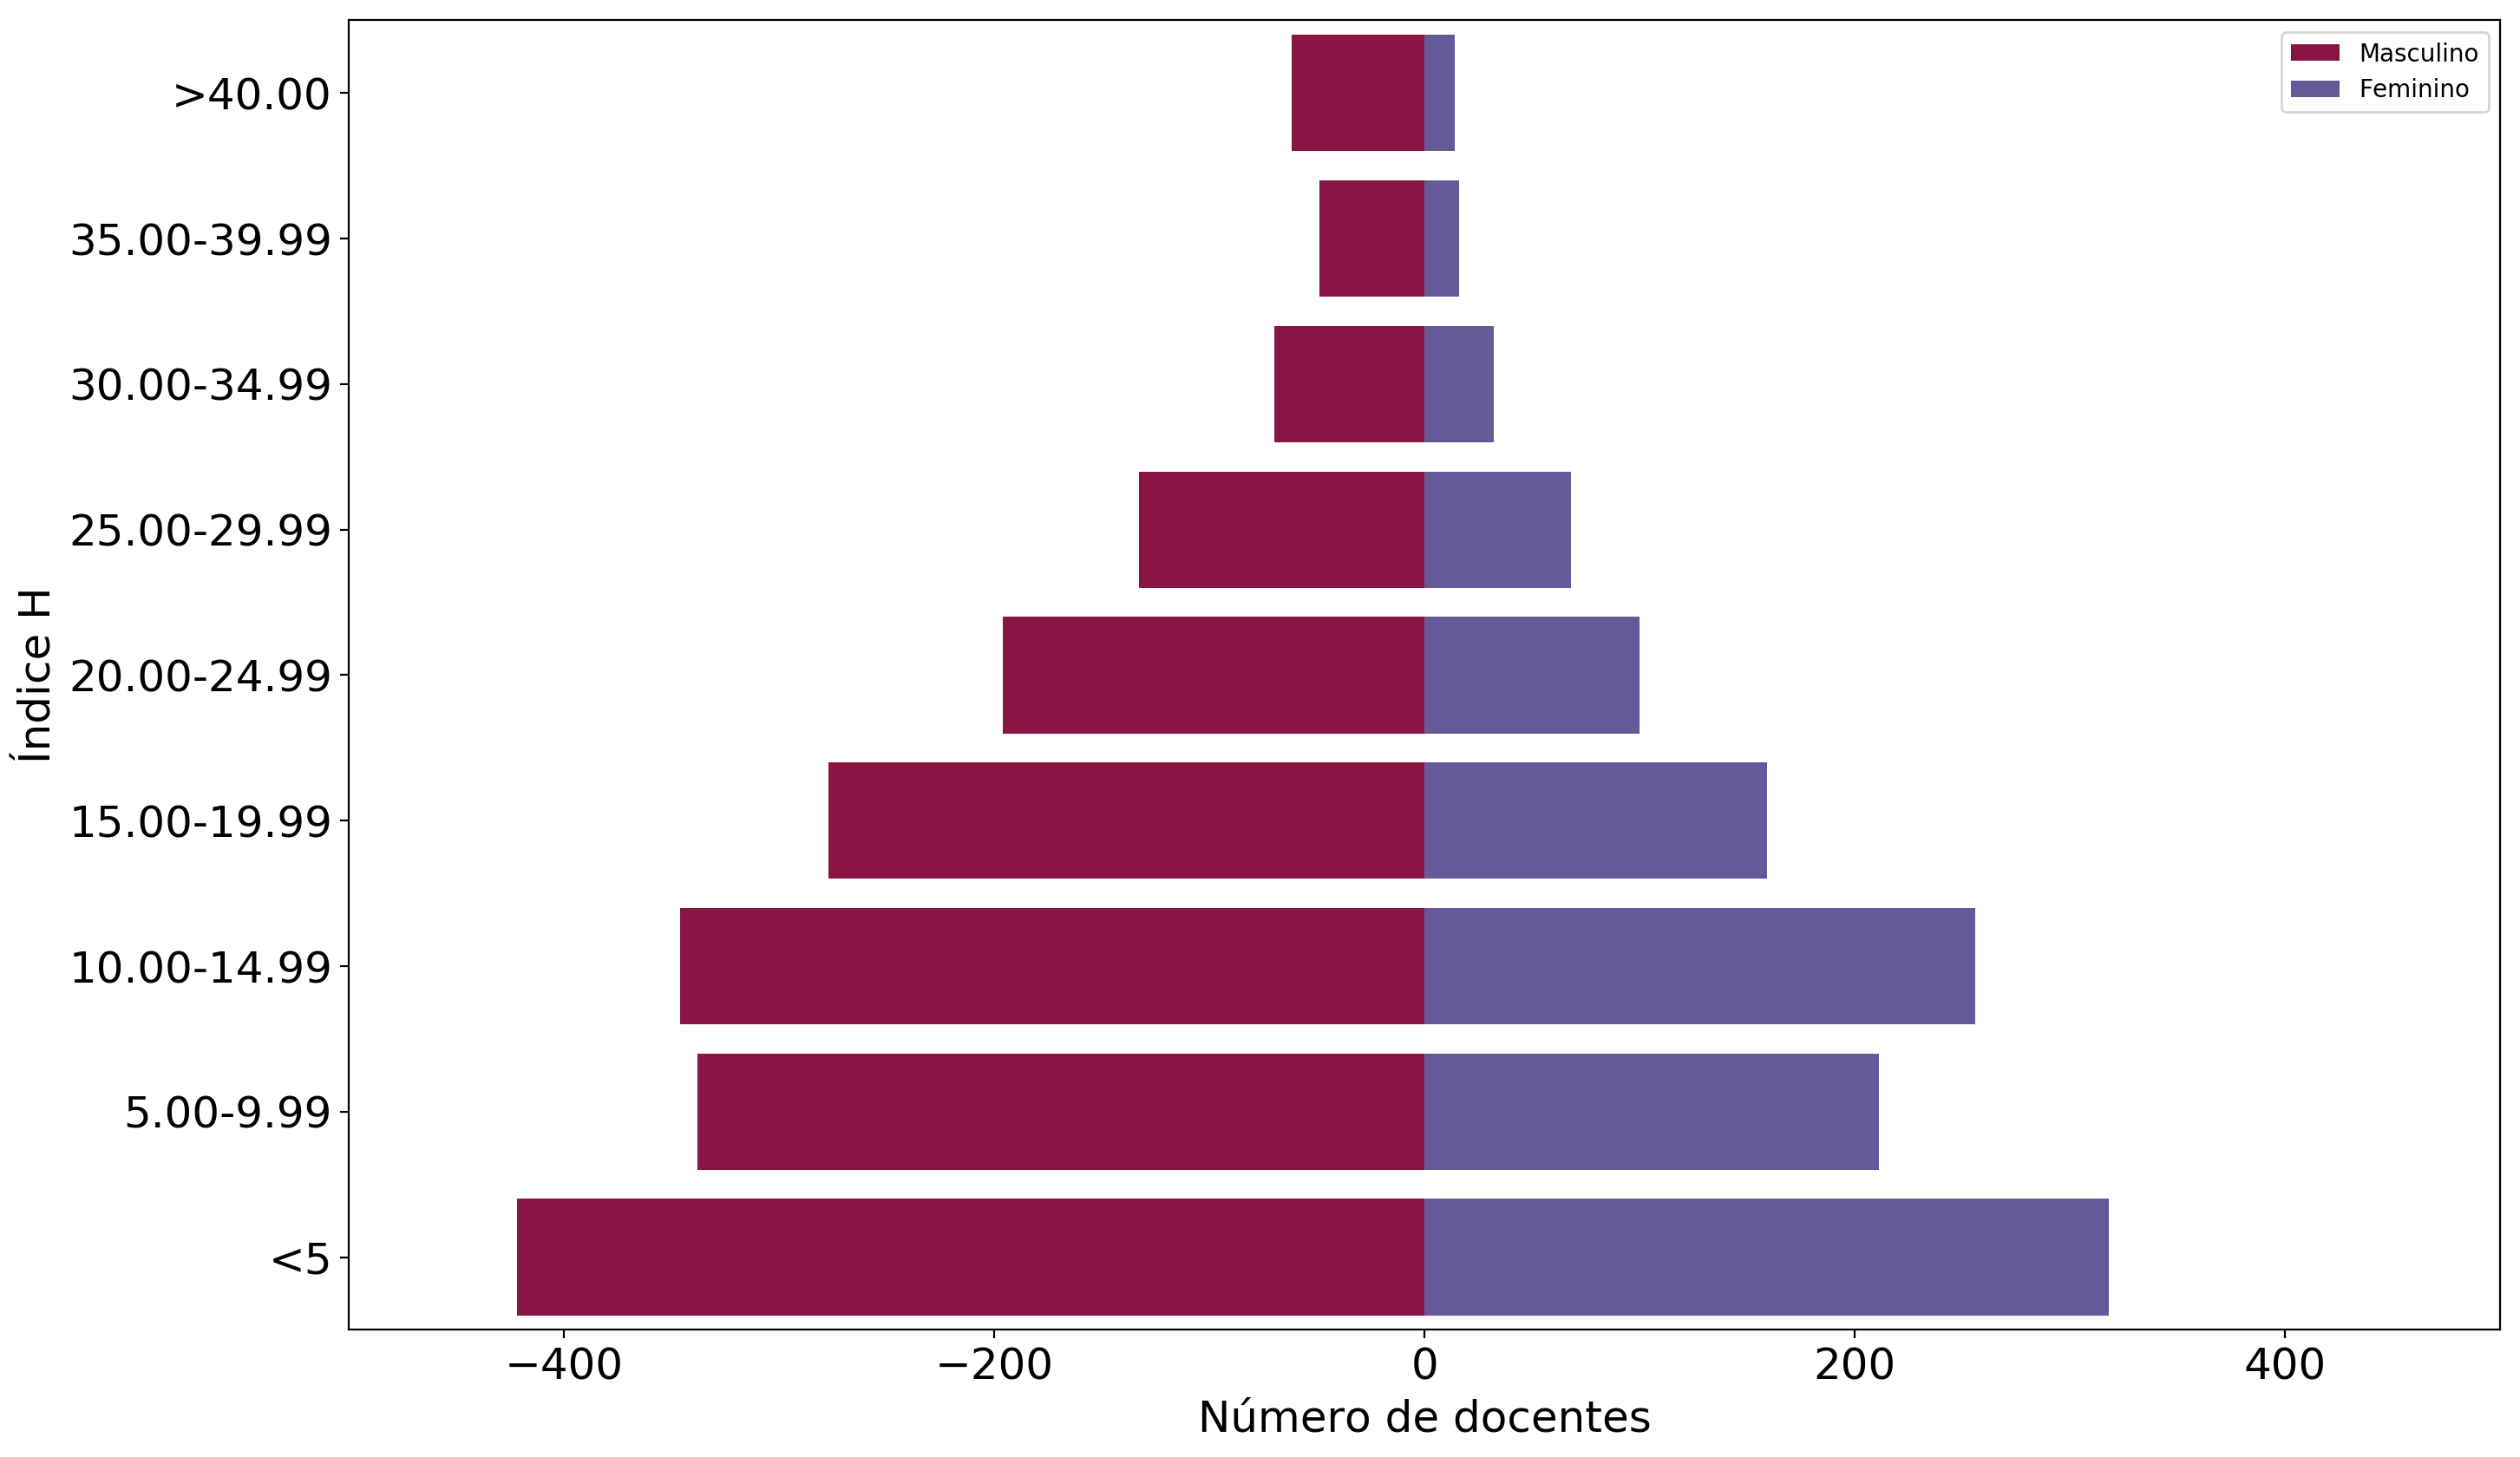

In [285]:
##Análise com intervalo de 5
faixa_bins = [0,5,9.99,14.99,19.99,24.99,29.99,34.99,39.99,500]
faixa_label = ['<5','5.00-9.99','10.00-14.99','15.00-19.99','20.00-24.99','25.00-29.99','30.00-34.99','35.00-39.99','>40.00']

########### Análise para a população geral
##Recategoriza o indice H em faixas
h_index_categorico = pd.cut(banco_completo_com_depto.h_index, bins=faixa_bins, include_lowest=True, labels=faixa_label)
banco_h_categorico = pd.concat([banco_completo_com_depto, h_index_categorico.rename("hIndexCat")], axis=1)
agrupado = banco_h_categorico.groupby("gender")

prop_genero = calculaProporcaoQualitativoMultiCategoria(agrupado, "hIndexCat")
intervalosPRO = calculaProporcao_IC(agrupado, "hIndexCat")

criaPiramideDoIndiceH(prop_genero);


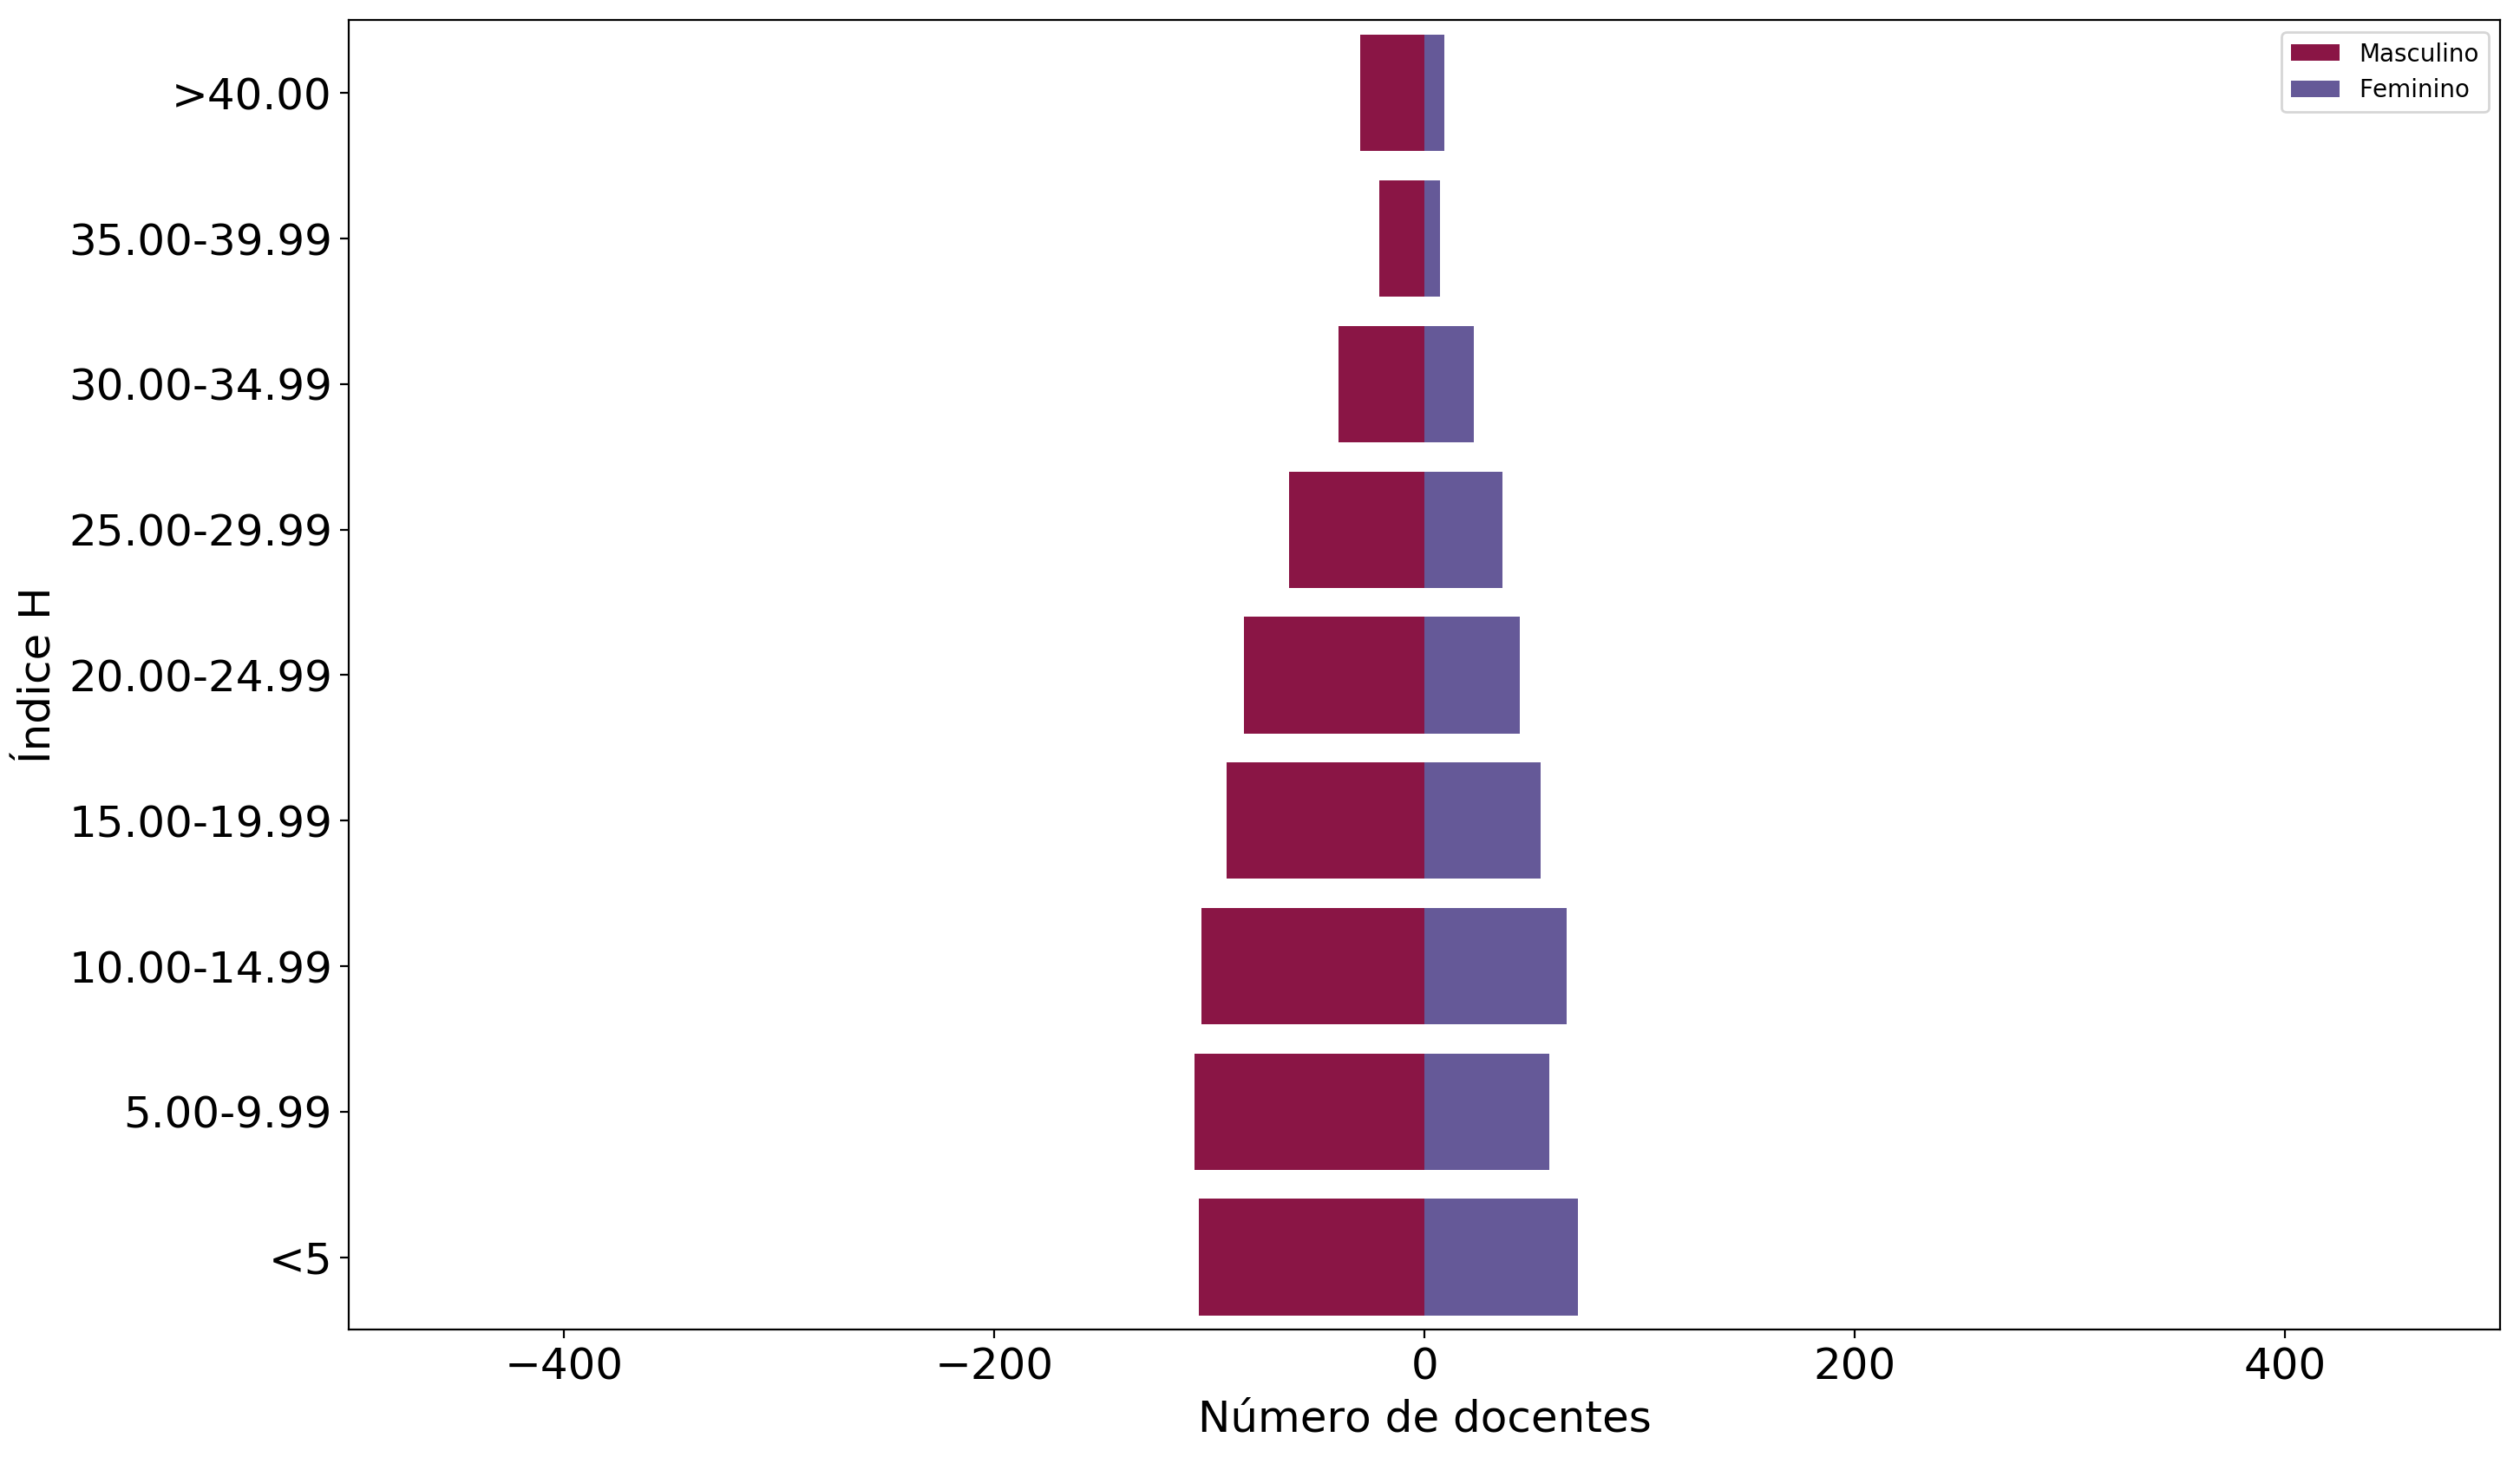

In [286]:
########### Análise para a população com <= 20 anos de serviço
#num_anos = 20
#result_20_anos = banco_completo_com_depto[banco_completo_com_depto["time"] <= num_anos]
result_20_anos.shape

h_index_categorico = pd.cut(result_20_anos.h_index, bins=faixa_bins, include_lowest=True, labels=faixa_label)
banco_h_categorico = pd.concat([result_20_anos, h_index_categorico.rename("hIndexCat")], axis=1)
agrupado_20 = banco_h_categorico.groupby("gender")

prop_genero_20 = calculaProporcaoQualitativoMultiCategoria(agrupado_20, "hIndexCat")
intervalosPRO_20 = calculaProporcao_IC(agrupado_20, "hIndexCat")
criaPiramideDoIndiceH(prop_genero_20, nome_figura="pop_20");


C:\Users\Livia Ciabati\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars


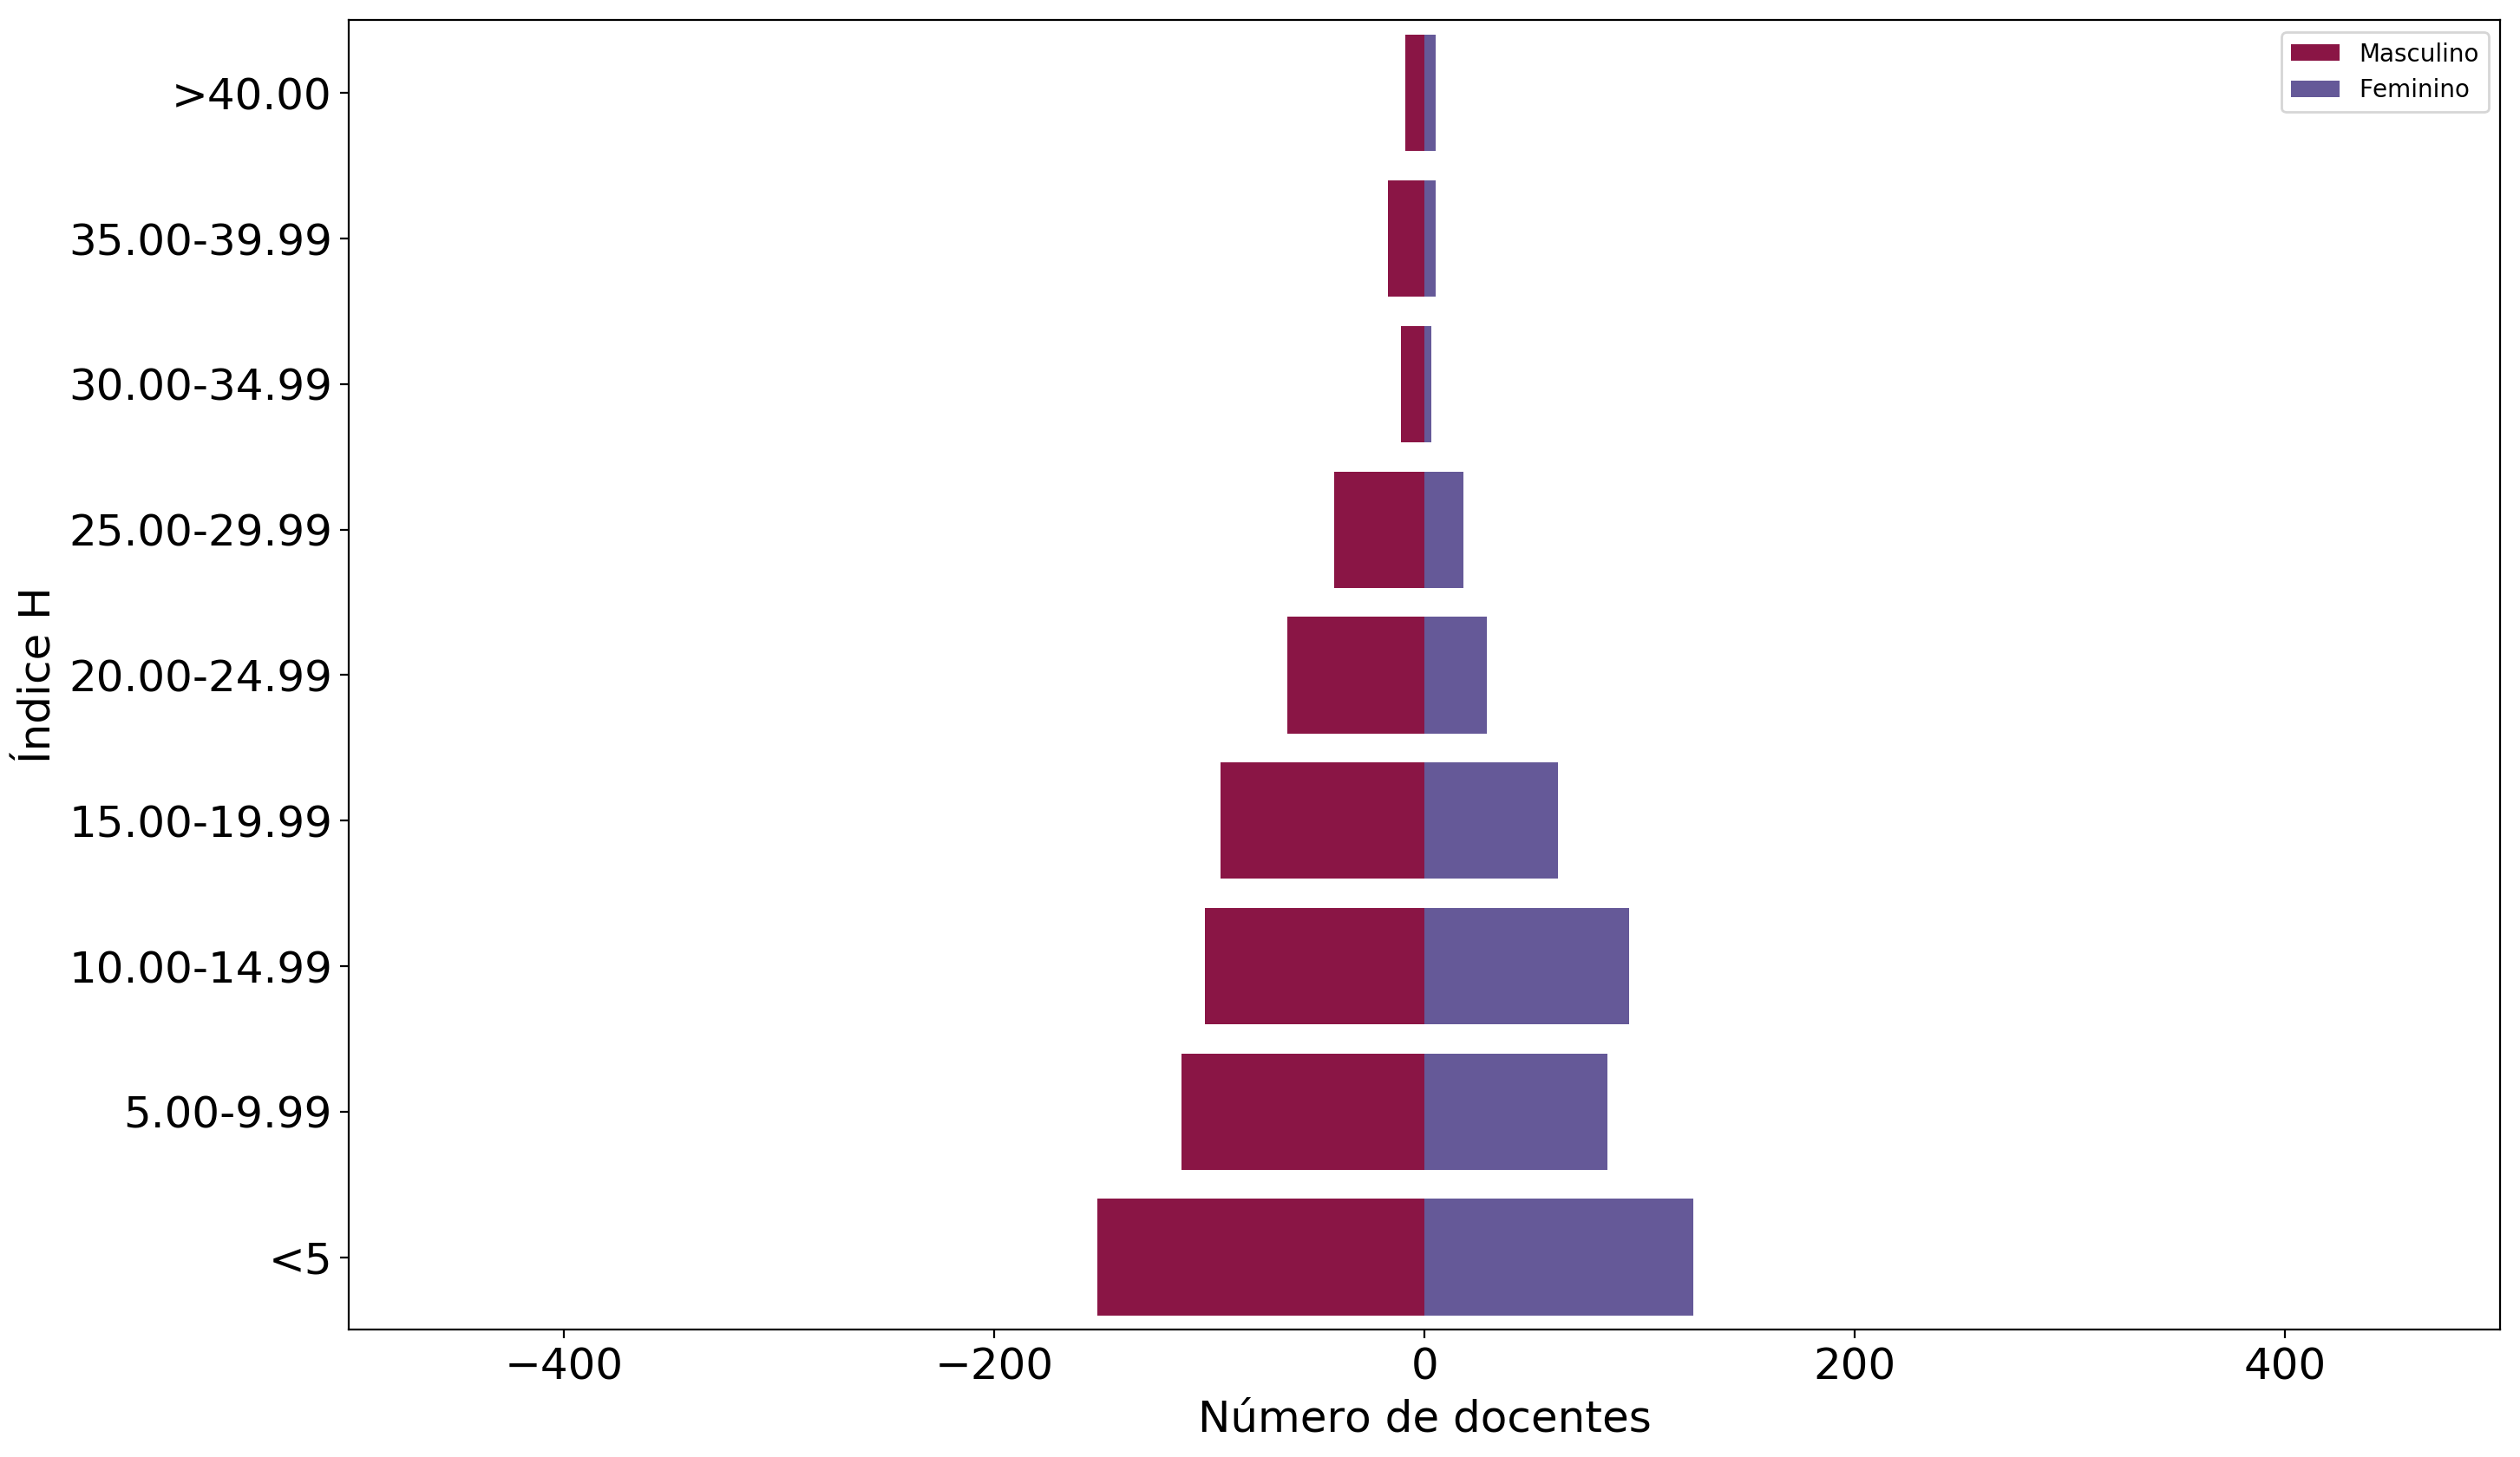

In [287]:
result_10_19_anos.shape

h_index_categorico = pd.cut(result_10_19_anos.h_index, bins=faixa_bins, include_lowest=True, labels=faixa_label)
banco_h_categorico = pd.concat([result_10_19_anos, h_index_categorico.rename("hIndexCat")], axis=1)
agrupado_10_19 = banco_h_categorico.groupby("gender")

prop_genero_10_19 = calculaProporcaoQualitativoMultiCategoria(agrupado_10_19, "hIndexCat")
intervalosPRO_10_19 = calculaProporcao_IC(agrupado_10_19, "hIndexCat")
criaPiramideDoIndiceH(prop_genero_10_19, nome_figura="pop_10_19");


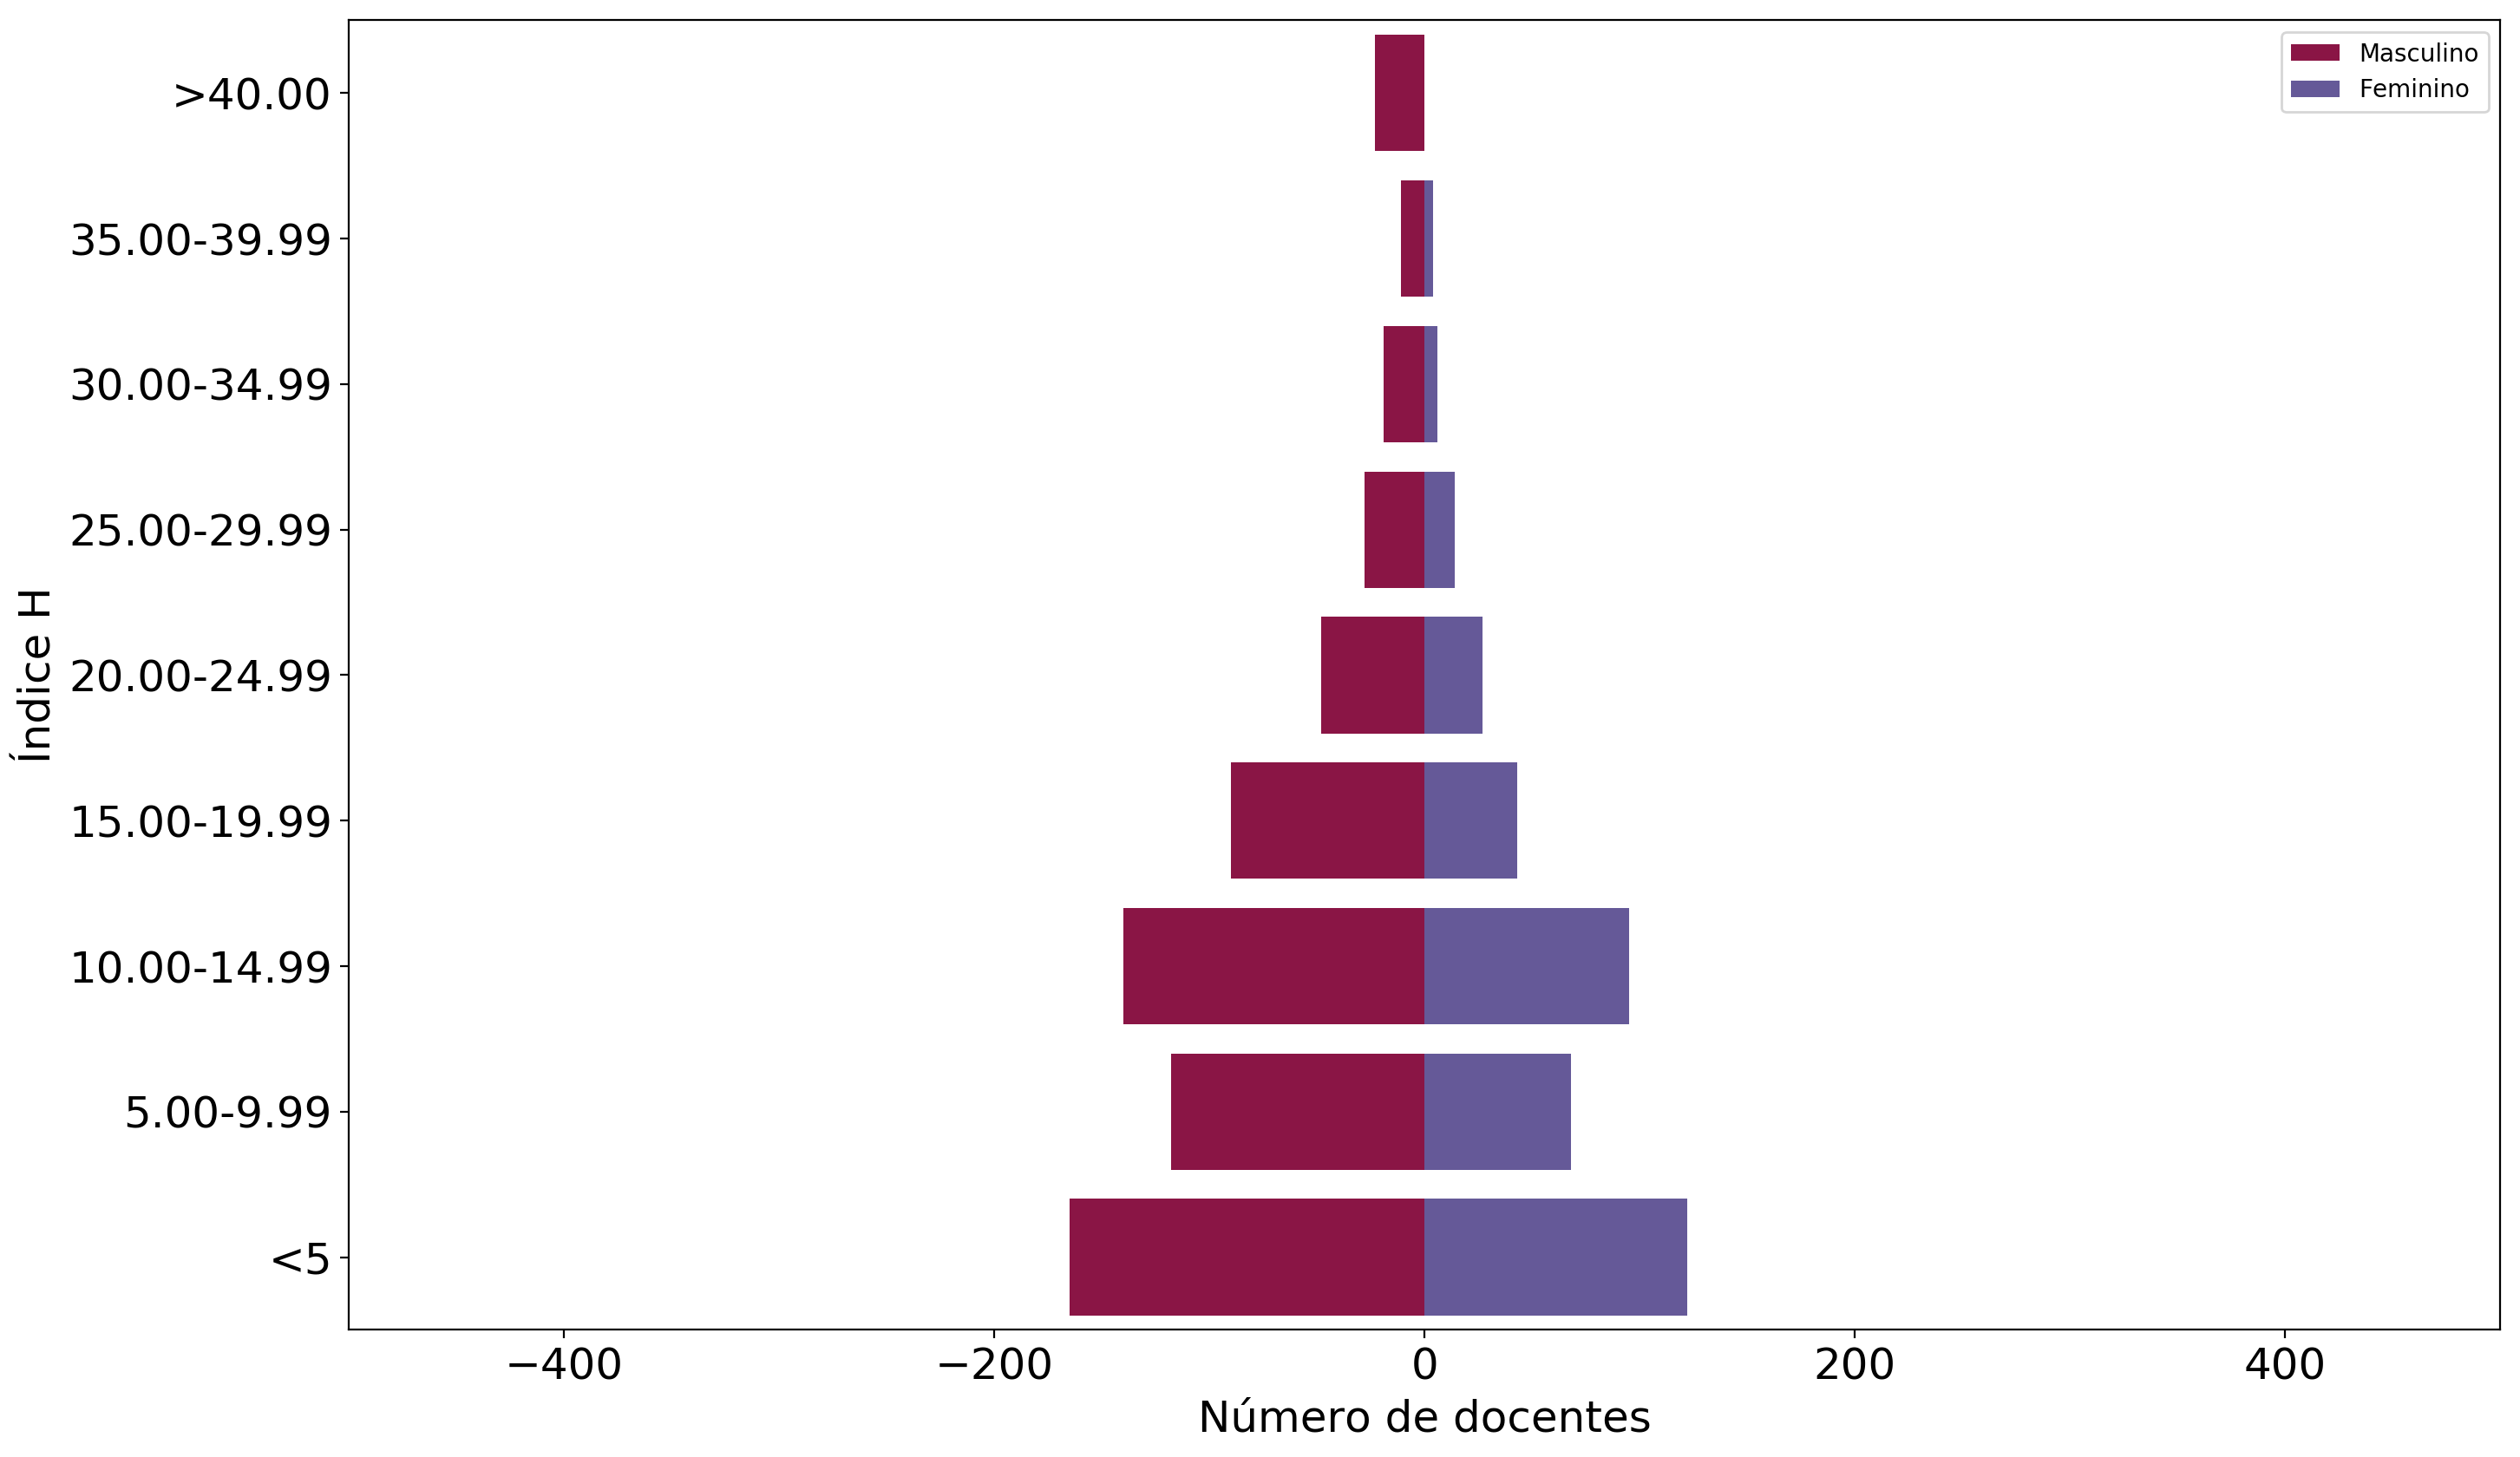

In [288]:
########### Análise para a população com <= 10 anos de serviço
#num_anos = 10
#result = banco_completo_com_depto[banco_completo_com_depto["time"] <= num_anos]
result_10_anos.shape

h_index_categorico = pd.cut(result_10_anos.h_index, bins=faixa_bins, include_lowest=True, labels=faixa_label)
banco_h_categorico = pd.concat([result_10_anos, h_index_categorico.rename("hIndexCat")], axis=1)
agrupado_10 = banco_h_categorico.groupby("gender")

prop_genero_10 = calculaProporcaoQualitativoMultiCategoria(agrupado_10, "hIndexCat")
intervalosPRO_10 = calculaProporcao_IC(agrupado_10, "hIndexCat")
criaPiramideDoIndiceH(prop_genero_10, nome_figura="pop_10");


In [289]:
writer = pd.ExcelWriter(path + "analise_professores_rr_bin_10.xlsx", engine = 'xlsxwriter')
prop_genero.to_excel(writer, sheet_name = 'prop_genero')
intervalosPRO.to_excel(writer, sheet_name = 'intervalos')

prop_genero_20.to_excel(writer, sheet_name = 'prop_genero_20')
intervalosPRO_20.to_excel(writer, sheet_name = 'intervalos_20')

prop_genero_10_19.to_excel(writer, sheet_name = 'prop_genero_10_19')
intervalosPRO_10_19.to_excel(writer, sheet_name = 'intervalosPRO_10_19')

prop_genero_10.to_excel(writer, sheet_name = 'prop_genero_10')
intervalosPRO_10.to_excel(writer, sheet_name = 'intervalos_10')

writer.save()
writer.close()